In [62]:
from pathlib import Path
def read_file(file_name):
    path = Path(file_name)
    if not path.exists():
        print("File not found")
        return None

    text = path.read_text(encoding="utf-8", errors="ignore")
    lines = text.splitlines()
    print("Total lines in file:", len(lines))
    return lines

In [63]:
def get_instance_info(lines, instance_name):
    start = None
    for i, line in enumerate(lines):
        if line.strip().lower() == f"instance {instance_name.lower()}":
            start = i
            break

    if start is None:
        print("Instance not found")
        return None, None, None

    j = start + 1
    while j < len(lines):
        parts = lines[j].split()
        if len(parts) >= 2 and parts[0].isdigit():
            n_jobs = int(parts[0])
            n_machines = int(parts[1])
            break
        j += 1

    return start, n_jobs, n_machines
    print("Instance:", instance_name)
    print("Jobs:", n_jobs, "Machines:", n_machines)

In [64]:
def extract_jobs(lines, start, n_jobs):
    jobs = []
    j = start + 1
    # move to the line that has job/machine numbers
    while j < len(lines):
        parts = lines[j].split()
        if len(parts) >= 2 and parts[0].isdigit():
            break
        j += 1

    j += 1  # move to first job line
    count = 0
    while count < n_jobs and j < len(lines):
        parts = lines[j].split()
        # only process line if it starts with a number
        if len(parts) > 0 and parts[0].isdigit():
            nums = list(map(int, parts))
            job = []

            for k in range(0, len(nums), 2):
                job.append((nums[k], nums[k+1]))
            jobs.append(job)
            count += 1
        j += 1
    return jobs    
    print("Loaded", len(jobs), "jobs")

In [65]:
lines = read_file("jobshop.txt")
start, n_jobs, n_machines = get_instance_info(lines, "ft06")
jobs = extract_jobs(lines, start, n_jobs)
print(jobs[0])

Total lines in file: 2243
[(2, 1), (0, 3), (1, 6), (3, 7), (5, 3), (4, 6)]


In [66]:
import random
import math
def create_individual(jobs):
    solution = create_random_solution(jobs)
    sigma = random.uniform(0.1, 0.4)
    return [solution, sigma]

In [67]:
def create_random_solution(jobs):
    solution = []
    for i in range(len(jobs)):
        solution += [i] * len(jobs[i])
    random.shuffle(solution)
    return solution

In [68]:
def swap_neighbor(solution):
    sol2 = solution[:]
    i, j = random.sample(range(len(sol2)), 2)
    sol2[i], sol2[j] = sol2[j], sol2[i]
    return sol2

In [69]:
def mutate(ind):
    solution, sigma = ind
    tau = 0.2
    sigma = sigma * math.exp(tau * random.gauss(0,1))
    sigma = max(0.05, min(1, sigma))
    n_swaps = int(len(solution) * sigma)
    for _ in range(n_swaps):
        solution = swap_neighbor(solution)

    return [solution, sigma]

In [70]:
def makespan_from_solution(solution, jobs, n_machines):
    n_jobs = len(jobs)
    machine_ready = [0] * n_machines
    job_ready = [0] * n_jobs
    next_op = [0] * n_jobs

    for j in solution:
        op_idx = next_op[j]
        m, t = jobs[j][op_idx]
        start = max(job_ready[j], machine_ready[m])
        finish = start + t
        job_ready[j] = finish
        machine_ready[m] = finish
        next_op[j] += 1
        
    return max(job_ready)

In [71]:
def makespan_ES(ind, jobs, n_machines):
    return makespan_from_solution(ind[0], jobs, n_machines)

In [72]:
def ES_self_adaptive(jobs, n_machines, pop_size=20, iters=200):
    pop = [create_individual(jobs) for _ in range(pop_size)]

    for it in range(iters):
        children = [mutate([ind[0][:], ind[1]]) for ind in pop]

        all_pop = pop + children
        all_pop.sort(key=lambda x: makespan_ES(x, jobs, n_machines))
        pop = all_pop[:pop_size]

        best = makespan_ES(pop[0], jobs, n_machines)
        print("Iter", it, "Best:", best)

    return pop[0]

In [79]:
def simulated_annealing(jobs, n_machines, init_solution, iters=7000, T0=100.0, alpha=0.995):
    current = init_solution[:]
    current_ms = makespan_from_solution(current, jobs, n_machines)
    best = current[:]
    best_ms = current_ms
    T = T0
    history = []

    for _ in range(iters):
        candidate = swap_neighbor(current)
        cand_ms = makespan_from_solution(candidate, jobs, n_machines)
        delta = cand_ms - current_ms

        if delta < 0 or random.random() < math.exp(-delta / T):
            current = candidate
            current_ms = cand_ms

            if current_ms < best_ms:
                best = current[:]
                best_ms = current_ms
                
        history.append(best_ms)
        T *= alpha
    return best, best_ms, history

In [82]:
file = "jobshop.txt"
instance = "ft06"

lines = read_file(file)
start, n_jobs, n_machines = get_instance_info(lines, instance)
jobs = extract_jobs(lines, start, n_jobs)

print("\nEvolution Strategies :\n")
best_es = ES_self_adaptive(jobs, n_machines, pop_size=50, iters=200)
print("Best ES Makespan:", makespan_ES(best_es, jobs, n_machines))


print("\nSimulated Annealing :\n")
init_solution = create_random_solution(jobs)
best_sa, best_ms, history = simulated_annealing(jobs, n_machines, init_solution)
print("Best SA Makespan:", best_ms)


Total lines in file: 2243

Evolution Strategies :

Iter 0 Best: 64
Iter 1 Best: 64
Iter 2 Best: 64
Iter 3 Best: 64
Iter 4 Best: 64
Iter 5 Best: 64
Iter 6 Best: 64
Iter 7 Best: 64
Iter 8 Best: 60
Iter 9 Best: 60
Iter 10 Best: 60
Iter 11 Best: 59
Iter 12 Best: 59
Iter 13 Best: 59
Iter 14 Best: 59
Iter 15 Best: 59
Iter 16 Best: 59
Iter 17 Best: 59
Iter 18 Best: 59
Iter 19 Best: 59
Iter 20 Best: 59
Iter 21 Best: 58
Iter 22 Best: 58
Iter 23 Best: 58
Iter 24 Best: 58
Iter 25 Best: 58
Iter 26 Best: 58
Iter 27 Best: 58
Iter 28 Best: 58
Iter 29 Best: 58
Iter 30 Best: 58
Iter 31 Best: 58
Iter 32 Best: 58
Iter 33 Best: 58
Iter 34 Best: 58
Iter 35 Best: 58
Iter 36 Best: 58
Iter 37 Best: 58
Iter 38 Best: 58
Iter 39 Best: 58
Iter 40 Best: 57
Iter 41 Best: 57
Iter 42 Best: 57
Iter 43 Best: 57
Iter 44 Best: 57
Iter 45 Best: 57
Iter 46 Best: 57
Iter 47 Best: 57
Iter 48 Best: 57
Iter 49 Best: 57
Iter 50 Best: 57
Iter 51 Best: 57
Iter 52 Best: 57
Iter 53 Best: 57
Iter 54 Best: 57
Iter 55 Best: 57
Iter 56

Plotting ES Result (Makespan: 55)


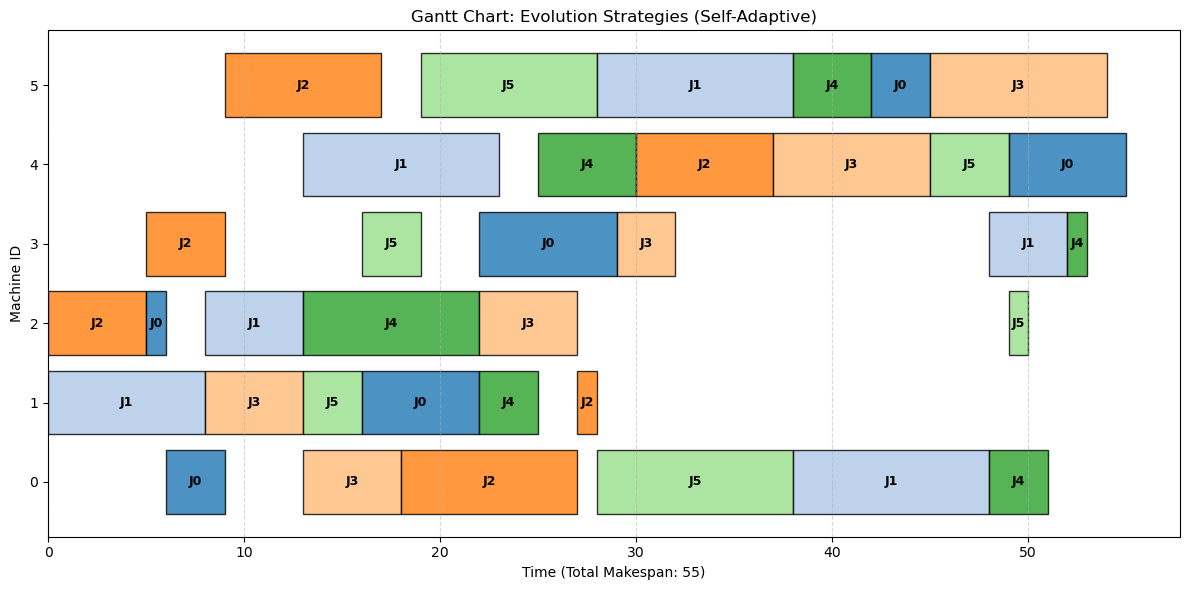

Plotting SA Result (Makespan: 55)


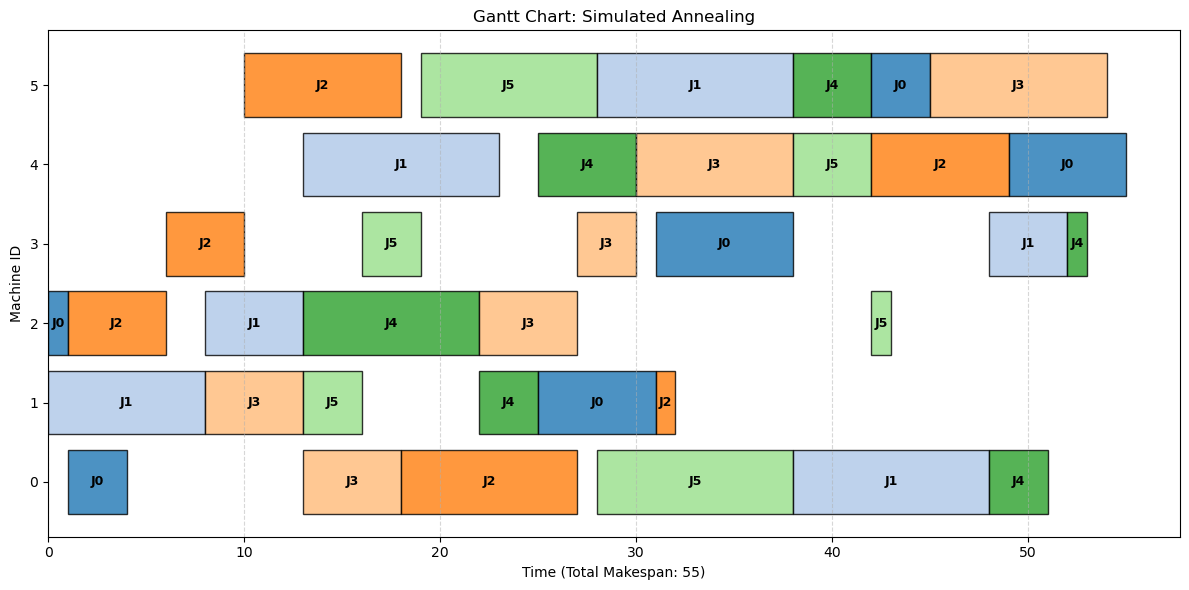

In [83]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def plot_schedule(solution_data, jobs, title="Job Shop Schedule"):
    if isinstance(solution_data[0], list):
        solution = solution_data[0]
    else:
        solution = solution_data

    job_next = [0] * len(jobs)
    job_time = [0] * len(jobs)
    machine_time = {}
    schedule = []  

    for j in solution:
        op_idx = job_next[j]
        m, t = jobs[j][op_idx]
        start = max(job_time[j], machine_time.get(m, 0))
        finish = start + t
        schedule.append((m, j, start, finish))
        job_time[j] = finish
        machine_time[m] = finish
        job_next[j] += 1
    
    plt.figure(figsize=(12, 6))
    # Using a colormap for distinct job colors
    colors = plt.colormaps['tab20'](range(len(jobs)))
    
    for m, j, start, finish in schedule:
        plt.barh(y=m, width=finish-start, left=start, height=0.8, 
                 color=colors[j], edgecolor='black', alpha=0.8)
        plt.text(x=start + (finish-start)/2, y=m, s=f"J{j}", 
                 va='center', ha='center', color='black', fontsize=9, fontweight='bold')
    
    plt.xlabel("Time (Total Makespan: {})".format(max(job_time)))
    plt.ylabel("Machine ID")
    plt.title(title)
    plt.yticks(range(int(max([m for m,_,_,_ in schedule]) + 1)))
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 1. Evolution Strategy Plot
print(f"Plotting ES Result (Makespan: {makespan_ES(best_es, jobs, n_machines)})")
plot_schedule(best_es, jobs, title="Gantt Chart: Evolution Strategies (Self-Adaptive)")

# 2. Simulated Annealing Plot
print(f"Plotting SA Result (Makespan: {best_ms})")
plot_schedule(best_sa, jobs, title="Gantt Chart: Simulated Annealing")